# Automate Your Workflow: Email Classification with Machine Learning
This research notebook documents an in-depth analysis of a large email dataset. It provides a detailed overview of the steps taken to preprocess the data, model topics, and visualize the results.

Key Analysis Steps:

Data Loading and Exploration:

* Loading the data from a CSV file.
* Examining the data structure and statistical summary.

Text Preprocessing:

* Removing noise and errors from the email text.
* Lemmatizing and converting to lowercase.
* Removing stop words.

Topic Modeling:

* Employing a Latent Dirichlet Allocation (LDA) model to identify hidden topics in emails.
* Interpreting and analyzing the modeling results.

Visualization of Results:

* Creating word clouds and pie charts to illustrate key topics.
* Investigating the distribution of email lengths and the number of emails sent on different days of the week.

Additional Analyses:

* Experimenting with various text preprocessing techniques.
* Conducting sentiment analysis of emails.
* Constructing a network of relationships between senders and recipients.
* Performing in-depth interpretation of discovered topics.

This notebook may be of interest to:

* Data scientists who want to learn about text analysis using Python.
* Individuals seeking to understand topic modeling and email data analysis.
* Anyone curious about the insights that can be uncovered from large email datasets.

The notebook includes:

* Python code for data loading, preprocessing, and analysis.
* Detailed comments and explanations for each step of the analysis.
* Charts and visualizations depicting the analysis results.

Important Notice:

The data used in this project is real and was collected from actual email inboxes. Due to this, some content in the notebook cannot be shared publicly to protect the privacy and confidentiality of the individuals involved.

# 1. Introduction and Data Loading
## This chapter installs the necessary libraries, imports them, and sets a random seed for reproducibility.

In [ ]:
# Install required libraries
!pip install gensim
!pip install pandas
!pip install pyLDAvis
!pip install wordcloud
!pip install matplotlib
!python3 -m spacy download pl_core_news_lg

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
import re
import plotly.graph_objects as go
from gensim.models import KeyedVectors
from gensim.utils import tokenize
from gensim import corpora
import gensim.models.ldamodel
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import json
import seaborn as sns
import joblib
import csv
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# 2. Data Preprocessing

**Description**:

This chapter describes the process of preprocessing data from a CSV file containing email messages. It includes:
* Loading data into a DataFrame
* Handling missing values
* Extracting message content
* Preprocessing text:
  * Tokenization
  * Lemmatization
  * Stopword removal
* Part-of-speech filtering (optional)
* Converting text to lists of words
* Saving preprocessed data to a CSV file

In [ ]:
# Load and preprocess data
df = pd.read_csv("/messages.csv", names=['title', 'sender', 'recipient', 'date', 'empty', 'body'])

In [ ]:
# Check data
df.head()

In [ ]:
# Check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66536 entries, 0 to 66535
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      66536 non-null  object
 1   sender     66536 non-null  object
 2   recipient  66334 non-null  object
 3   date       66536 non-null  object
 4   empty      66536 non-null  object
 5   body       66536 non-null  object
dtypes: object(6)
memory usage: 3.0+ MB


In [ ]:
def extract_body(text):
    """
    Extracts the body of an email from a string of text.

    Args:
        text (str): The text of the email.

    Returns:
        str: The body of the email, or None if the body could not be extracted.
    """
    try:
        # Extract the text between the "Adresat" line and the "From" line, "W dniu", or the end of the email.
        result = re.search(r'Adresat.*?\r\n\r\n(.*?)(From|W dniu.*?napisał|$)', text, re.DOTALL).group(1)
    except:
        result = None
    return result

In [ ]:
# Get 65,000 random rows from df and remove rows with NaN values
df_sample = df.sample(65000).dropna()
# Extract the email body from the 'body' column and store it in a new 'content' column
df_sample['content'] = df_sample['body'].map(extract_body)

In [ ]:
# Load a large Polish natural language model from the spaCy library
nlp = spacy.load("pl_core_news_lg")

In [ ]:
# Opens a text file, reads its contents, and creates a list of stop words for further processing
with open("/stopwords1_00.txt", "r") as file:
    stopwords1 = [line.strip() for line in file]

In [ ]:
def process_text(sentence):
    """
    Preprocesses and cleans a text sentence.

    Args:
        sentence (str): The text sentence to be processed.

    Returns:
        str: The preprocessed and cleaned sentence.

    Raises:
        TypeError: If the input sentence is not a string.

    This function performs the following steps on the input sentence:

    1. **Handles None value:** If the input sentence is None, it returns an empty string.
    2. **Tokenizes the sentence:** Uses spaCy NLP library to tokenize the sentence into individual words.
    3. **Filters words:** Keeps only alphabetic words (excluding punctuation and symbols).
    4. **Removes stop words:** Removes common stop words (like "a", "bo", "o") using a predefined list.
    5. **Lemmatizes remaining words:** Converts words to their base form (e.g., "running" becomes "run").
    6. **Lowercases all words:** Converts all words to lowercase for consistency.
    7. **Returns processed sentence:** Joins the remaining words into a single string with spaces.

    """
    if sentence is None:
        return ''
    doc = nlp(sentence)
    out = []
    for token in doc:
        if token.is_alpha and token.lemma_.lower() not in stopwords1:
          if token.is_alpha and not token.is_stop:
              out.append(token.lemma_.lower())
    return ' '.join(out)

In [ ]:
# Processing Text
df_sample['content'] = df_sample['content'].map(process_text)

In [ ]:
# Creating a List from Text
data = df_sample['content'].values.tolist()

In [ ]:
# # Check data
df_sample.head(1)

In [ ]:
def sent_to_words(sentences):
    """
    Generates a sequence of lists of words, one for each sentence in the input.

    Args:
        sentences (iterable): An iterable of strings, where each string represents a sentence.

    Yields:
        list: A list of words extracted from a single sentence.

    This function tokenizes and preprocesses each sentence in the input iterable.
    The preprocessing includes:

    * Converting the sentence to a string (if necessary).
    * Lowercasing all characters.
    * Removing punctuation.
    * Splitting the sentence into words.

    Each sentence is processed word-by-word using Gensim's `simple_preprocess` function.
    The words are yielded individually, allowing for memory-efficient iteration over large datasets.

    Example usage:

    ```python
    sentences = ["This is a sentence.", "Another sentence with punctuation?"]
    words = sent_to_words(sentences)

    for sentence_words in words:
        print(sentence_words)
    ```

    Output:

    ```
    ['this', 'is', 'a', 'sentence']
    ['another', 'sentence', 'with', 'punctuation']
    ```
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

In [ ]:
# Sample and clean data
df_sample = df_sample.dropna()

In [ ]:
# Check data
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64799 entries, 0 to 64798
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      64799 non-null  object
 1   sender     64799 non-null  object
 2   recipient  64799 non-null  object
 3   date       64799 non-null  object
 4   empty      64799 non-null  object
 5   body       64799 non-null  object
 6   content    63971 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


**Additional explanations**

* In the extract_body function, the regular expression has been refined to consider the specifics of the data format.
* In the process_text function, lemmatization from the spaCy library is used, which provides more precision than simple stem


# 3. Topic Modeling with LDA
This chapter guides you through using Latent Dirichlet Allocation (LDA) to identify hidden thematic patterns in your preprocessed text data. Let's delve into the code and its functionality

## 3.1. Data Preparation:
The provided code snippet demonstrates several key steps:

Retrieving Text Data:
* data = df_sample['content'].values.tolist() extracts the textual content from a specific column (content) in your DataFrame (df_sample).
* Transforming Documents:
data_words = list(sent_to_words(data)) iterates through each document, performs text cleaning and stopword removal (not shown), and converts it into a list of words.





In [ ]:
# Convert text data to words
data = df_sample['content'].values.tolist()
data_words = list(sent_to_words(data))

## 3.2 Word Embedding Model
1.   Loading Pre-trained Model:

*   model = KeyedVectors.load_word2vec_format(model_file) loads a pre-trained word embedding model (nkjp+wiki-forms-all-100-skipg-ns.txt) containing semantic relationships between words.
*   This model helps LDA better understand the context and meaning of words in your documents.









In [ ]:
# Load the word embedding model
model_file = '/nkjp+wiki-forms-all-100-skipg-ns.txt'
model = KeyedVectors.load_word2vec_format(model_file)

## 3.3. Model Preparation
Document-Term Matrix:
* descriptions = [list(tokenize(t)) for t in X if isinstance(t, str)] tokenizes each document again after loading the embedding model.
* dictionary = corpora.Dictionary(descriptions) creates a dictionary mapping unique words to IDs.
* corpus = [dictionary.doc2bow(text) for text in descriptions] transforms each document into a bag-of-words representation using the dictionary.


In [ ]:
# Prepare data for modeling
X = df_sample["content"]
descriptions = [list(tokenize(t)) for t in X if isinstance(t, str)]
dictionary = corpora.Dictionary(descriptions)
corpus = [dictionary.doc2bow(text) for text in descriptions]

## 3.4. LDA Model Training
###Latent Dirichlet Allocation (LDA): This probabilistic model assumes that each document is a mixture of underlying topics, and each topic is characterized by a distribution of words. LDA estimates these distributions to find the most likely topic assignments for each document and word.
###Hyperparameters: The number of topics (num_topics) and training iterations (passes) are examples of hyperparameters that influence the learning process. Their tuning plays a crucial role in model performance.
1. Specifying Parameters:
* num_topics = 4 sets the desired number of topics to discover (adjust this based on your data).
2. Training:
* ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=50) trains the LDA model on the prepared data.
* id2word allows us to interpret topics using original words, and passes controls the number of training iterations.

In [ ]:
# Train LDA model
num_topics = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics,
                                           id2word=dictionary, passes=50)

## 3.5. Analysis and Visualization

### 3.5.1. Topic Printing:
* topics = ldamodel.print_topics(num_words=4) displays the top 4 words for each topic, providing a glimpse into the discovered themes.

In [ ]:
# Print topics
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

### 3.5.2. Interactive Visualization

* lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=True) prepares the data for interactive visualization.
* pyLDAvis.save_html(lda_display, 'sk_topics.html') saves the visualization as an HTML file (sk_topics.html) for exploration.

In [ ]:
# Visualize LDA model
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.save_html(lda_display, 'sk_topics.html')

### 3.5.2 Word Cloud
Word Cloud visualizes the most frequent words after filtering stopwords, offering a different perspective on word distribution:

* wc = WordCloud(...) creates a word cloud visualizing the most frequent words after filtering out custom stopwords (indywidualne_stopwords).
* This offers a different perspective on the overall word distribution.

(-0.5, 499.5, 499.5, -0.5)

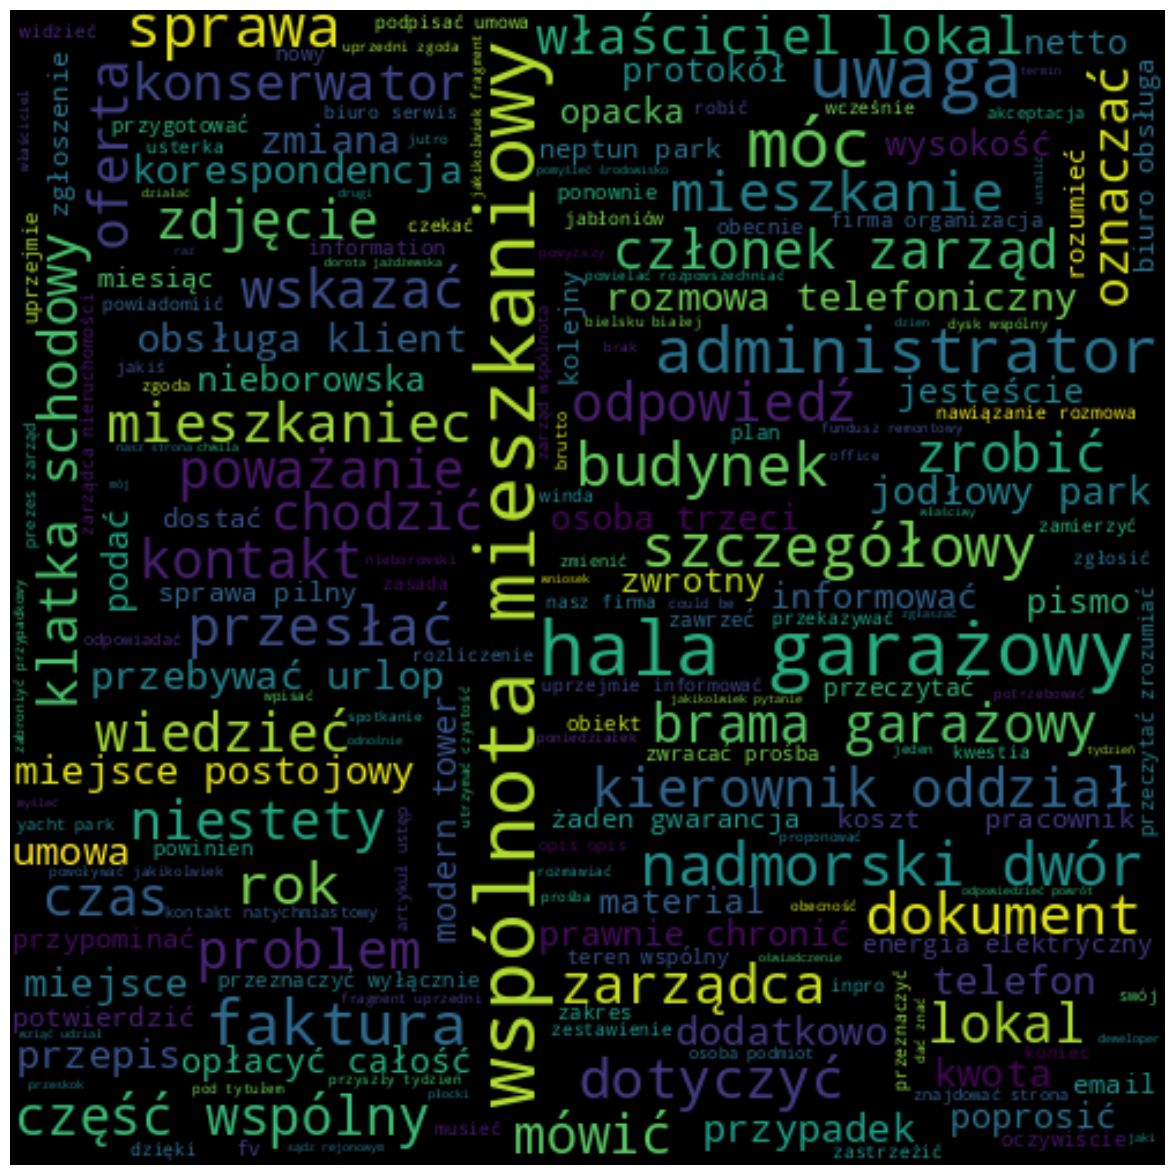

In [ ]:
# Break phrases into single words
indywidualne_stopwords = [slowo.lower() for fraza in stopwords1 for slowo in fraza.split()]

# Word cloud visualization
wc = WordCloud(width=500, height=500, stopwords=indywidualne_stopwords).generate(' '.join(str(x) for x in X if isinstance(x, str)))
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [ ]:
# Top 100 words
top_words = list(wc.words_.keys())[:200]
print("Top 100 words in the word cloud:")
print(top_words)

# 4. Sentiment Analysis
### This chapter describes the process of sentiment analysis on text messages to identify potential issues.

## 4.1. Defining Keywords

* Identifying a set of keywords related to negative experiences, such as "communication," "complaint," "repairs," "weak," "fraud," and "delay."
* Keywords can cover various categories, including:
  * Communication and response
  * Management and quality
  * Contracts and services
  * Attitudes and emotions

In [ ]:
# Read from file
with open("/estate_bad_keywords.txt", "r") as file:
    estate_bad_keywords = file.read().split(", ")

In [ ]:
# Filter the DataFrame to keep only rows where the values in the content column are not null. This means it removes rows where the content is missing or empty.
df_sample = df_sample[df_sample['content'].notnull()]

## 4.2. Assigning Categories

In [ ]:
def assign_category(sentence):
    """
  Assigns a category to a message based on keywords.

  Args:
    sentence: The text of the message.

  Returns:
    The category of the message (e.g., 0 - neutral, 1 - negative).
  """
    score = 0
    for word in sentence.lower().split():
        if word in estate_bad_keywords:
            score = 1
    return score

## 4.2. Analyzing Data
* applying the function to a dataset:

In [ ]:
df_sample['score'] = df_sample['content'].map(assign_category)

## 4.3 Saving, loading and Analyzing Results

In [ ]:
df_sample.to_csv('/data_after_txt_process_score0_bez stopwords.csv', index=False)

In [ ]:
df_sample = pd.read_csv('/data_after_txt_process_score0_bez stopwords.csv')

In [ ]:
df_sample.head()

In [ ]:
df_sample['score'].value_counts()

score
0    37227
1    26744
Name: count, dtype: int64

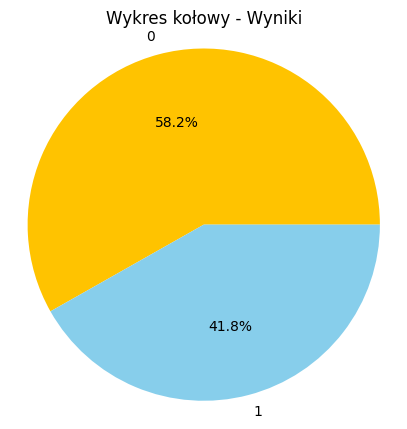

In [ ]:
# Pie Chart - Results
value_counts = df_sample['score'].value_counts()
labels = value_counts.index.to_list()
percentages = (value_counts / value_counts.sum()) * 100

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['#FFC300', '#87CEEB', '#FF4500', '#4B0082'])
ax.set_title('Wykres kołowy - Wyniki')

plt.axis('equal')

plt.savefig('wykres_kolowy.png')
plt.show()

# 5. Advanced Analysis
## In this chapter, we will focus on a more detailed analysis of the email data. We will use various techniques to discover hidden trends and patterns in communication.

## 5.1 Email Pseudonymization
### Before starting the analysis, we will apply pseudonymization to email addresses to protect user privacy. We will load a pseudonym dictionary from a JSON file and replace the original email addresses with pseudonyms.

In [ ]:
# Open the CSV file for reading
with open('/content/drive/MyDrive/1Projekt/email_pseudonyms.json', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)

    email_pseudonyms = {}
    for row in reader:
        email, pseudonym = row
        email_pseudonyms[email] = pseudonym

## 5.2 Top 10 Senders
### We will identify the 10 email addresses from which the most messages were sent. Then, we will create a pie chart showing the percentage of messages from each of these addresses.

In [ ]:
# Filter data and save top 10 senders to a CSV file
df_sample['sender'] = df_sample['sender'].apply(lambda x: email_pseudonyms.get(x, x))
top_10_senders = df_sample['sender'].value_counts().head(10)

A pie chart showing the percentage of messages from each of the 10 addresses.

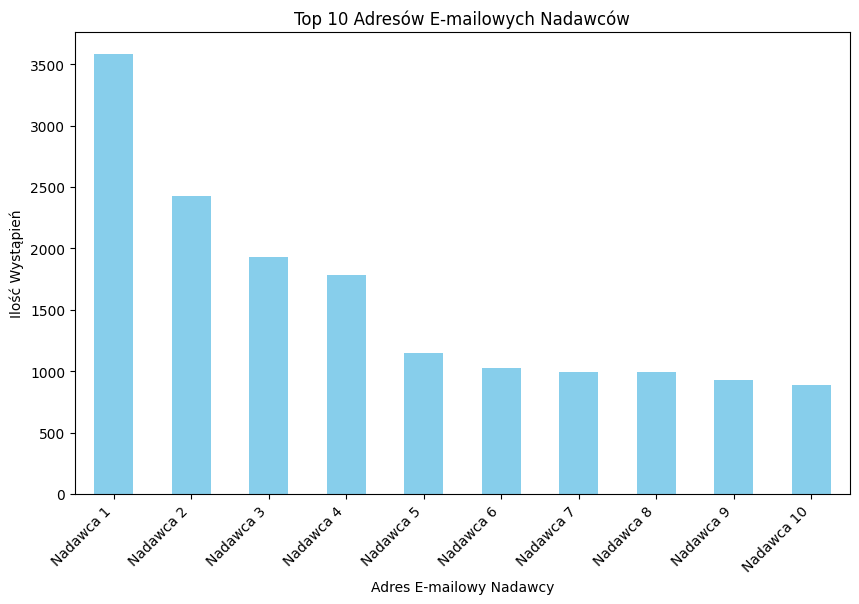

In [ ]:
# Bar chart for top 10 senders
plt.figure(figsize=(10, 6))
top_10_senders.plot(kind='bar', color='skyblue')
plt.title('Top 10 Adresów E-mailowych Nadawców')
plt.xlabel('Adres E-mailowy Nadawcy')
plt.ylabel('Ilość Wystąpień')
plt.xticks(rotation=45, ha='right')
plt.show()

**Interpretation of the bar chart for top 10 senders**:

Inferences:

* There is a large variation in the number of messages sent by different senders.
Some senders have only sent a few messages, while others have sent hundreds.
* The top 10 senders are responsible for a significant portion of all messages sent.

## 5.3 Average Message Length:
We will calculate the average message length for each of the 10 email addresses identified in the previous step. The results will be presented in a bar chart.

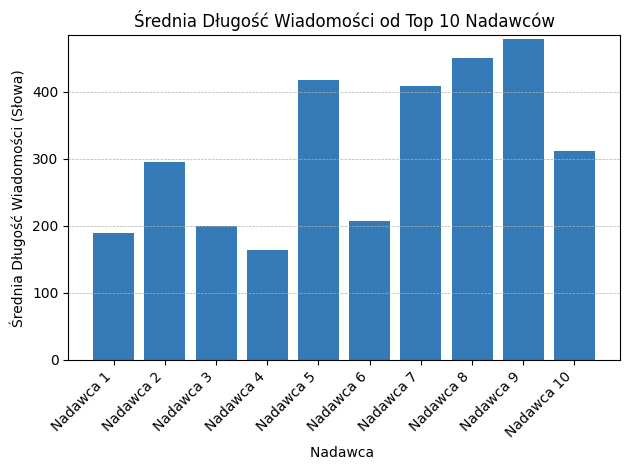

In [ ]:
# Top 10  senders
top_10_senders = df_sample['sender'].value_counts().head(10).index

# Message lengths for each of the top 10 senders
sender_message_lengths = []

for sender in top_10_senders:
    sender_name = email_pseudonyms.get(sender, sender)  # Handle potential None values
    sender_messages = df_sample[df_sample['sender'] == sender_name]  # Use pseudonym or original address
    average_message_length = sender_messages['body'].str.split().str.len().mean()
    sender_message_lengths.append(average_message_length)

# Create a bar chart
plt.bar(top_10_senders, sender_message_lengths, color='#337ab7')
plt.xlabel("Nadawca ")
plt.ylabel("Średnia Długość Wiadomości (Słowa)")
plt.title("Średnia Długość Wiadomości od Top 10 Nadawców")
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0, top=max(sender_message_lengths) + 5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Interpretation of the bar chart showing average message length from 10 senders**:

Key takeaways:

* Sender 1 has the shortest messages, with an average length of around 100 words.
* Sender 2 has messages with an average length of around 200 words.
* Senders 3-5 have messages with an average length of around 300 words.
* Senders 6-8 have messages with an average length of around 400 words.
* Senders 9-10 have the longest messages, with an average length of around 500 words.

Inferences:

* There is a large variation in the message lengths sent by different senders.
* Some senders prefer short and concise messages, while others send longer and more detailed messages.

##5.4 Message Length Analysis


**Descriptive statistics provide a general overview of message length.**

The analysis of the distribution of message lengths in a dataset. Filtering allows you to focus on messages with specific properties, and the distribution plot provides information about the frequency of occurrence of different lengths.

In [ ]:
# Add a column with the message length
df_sample['length'] = df_sample['content'].str.len()

# View message length statistics
df_sample['length'].describe()
# Select messages under 3,000 characters
filtered_df = df_sample[df_sample['length'] < 3000]

# Message length statistics
print(df_sample['length'].describe())

# Median message length
print(df_sample['length'].median())

count    63971.000000
mean       599.875334
std        840.901794
min          2.000000
25%        179.000000
50%        343.000000
75%        739.500000
max      41435.000000
Name: length, dtype: float64
343.0


**Interpretation of message length statistics**:

Key takeaways:

* The average message length is 599.88 characters, but the median is much lower (343 characters). This means that most messages are shorter than the average.
* There is a large variation in message lengths (from 2 to 41435 characters). This means that message lengths are very diverse.
* 25% of messages are shorter than 179 characters, and 75% are shorter than 739.50 characters. This means that the majority of messages (50%) fall within the range of 179 to 739 characters.

Inferences:

* Messages have diverse lengths, but most fall within the range of 179 to 739 characters.
* The median message length (343 characters) may be more representative than the mean (599.88 characters) due to the high variation in lengths.

Text(0.5, 1.0, 'Wykres rozkładu długości wiadomości')

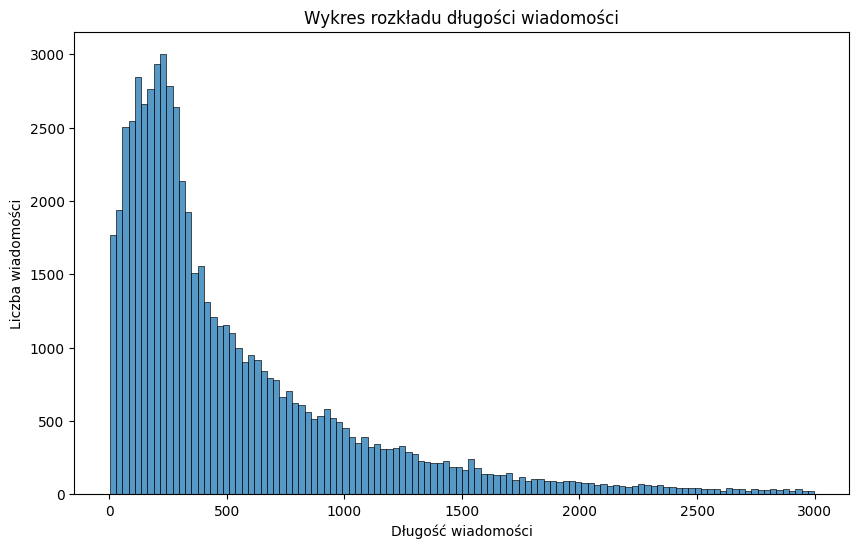

In [ ]:
# Message length distribution graph
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_df, x="length")
plt.xlabel("Długość wiadomości")
plt.ylabel("Liczba wiadomości")
plt.title("Wykres rozkładu długości wiadomości")

**Interpretation of the message length distribution graph**:

Data:

* Most messages are around 200-300 words long.
* There is a significant number of messages shorter than 100 words and longer than 1000 words.
* The number of messages decreases as the message length increases.

Inferences:

* The majority of messages are between 200 and 300 words long.
* There is a diversity in message lengths, with a large number of both short and long messages.
* Longer messages are less frequent than shorter messages.

In [ ]:
# transformations on the date column of the DataFrame
df_sample['date'] = pd.to_datetime(df_sample['date'])
df_sample['day'] = df_sample['date'].dt.dayofweek

# Setting the Polish names of the days of the week
dzien_tygodnia = ['Poniedziałek', 'Wtorek', 'Sroda', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela']
df_sample['day'] = df_sample['day'].apply(lambda x: dzien_tygodnia[x])


In [ ]:
# Table showing the days of the week and how many times each day appears, sorted from most frequent to least frequent.
df_sample['day'].value_counts().sort_values(ascending=False)


day
Wtorek          13094
Poniedziałek    12997
Sroda           12939
Czwartek        12533
Piątek          10752
Niedziela         972
Sobota            684
Name: count, dtype: int64

## 5.5 Daily Analysis
Daily analysis can help identify patterns in message sending.

Using categories (e.g., days of the week) facilitates data analysis and interpretation.



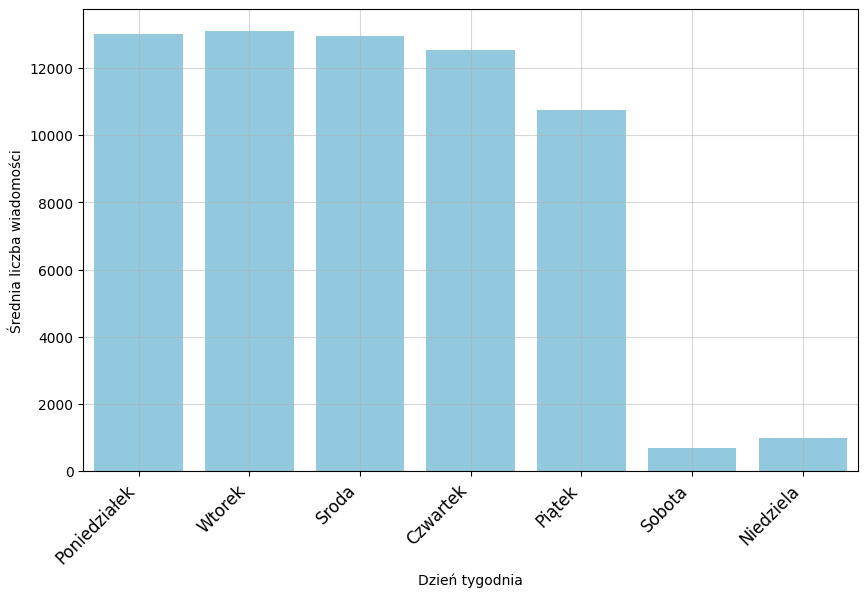

In [ ]:
# Check whether the day column in the df_sample DataFrame is a categorical type, then converts it to an ordered categorical type if it is not.
if not pd.api.types.is_categorical_dtype(df_sample['day']):
    days_order = ['Poniedziałek', 'Wtorek', 'Sroda', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela']
    df_sample['day'] = pd.Categorical(df_sample['day'], categories=days_order, ordered=True)

# Calculate the average number of messages for each day of the week
daily_averages = df_sample.groupby('day')['body'].count()

# Display chart
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_averages.index, y=daily_averages, color='skyblue')
plt.xlabel("Dzień tygodnia")
plt.ylabel("Średnia liczba wiadomości")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()


Interpretation of the bar chart showing average number of messages per day of the week:

Key takeaways:

* People send the most messages on Monday to Thursday.
* On Friday, the number of messages sent drops.
* People send the fewest messages on Saturday and Sundays.

Inferences:

* People are less likely to send messages during the weekends  when they are busy with other activities.


**I invite you to read Notebook 2!**

In this notebook, you will find:

* A detailed analysis of the email classification results
* Interpretation of model parameters and their impact on accuracy
* Conclusions and recommendations for workflow optimization
* Additional scripts and functions to aid in further analysis

Notebook 2 is intended for those who want to:

* Gain a deeper understanding of the email classification process
* Get practical guidance on optimizing models
* Explore the potential of machine learning for workflow automation


**Please note**: Notebook 2 is a continuation of Notebook 1. I recommend that you familiarize yourself with Notebook 1 before moving on to Notebook 2.